The top 2 models we evaluated were:
- HistGradBoostingClassifier, without scaled features and class_weights='balanced'
- KNeighborsClassifier, with scaled features and class_weights='balanced'

This was evaluated based on the average performance over multiple iterations of balanced datasets. 
- HistGradBoostingClassifier:
    - Accuracy: 85.1%
    - Average Precision for Class 1: 0.904
    - Average Recall for Class 1: 0.780
    - Average F1-Score for Class 1: 0.837

- KNeighborsClassifier
    - Accuracy: 83.63%
    - Average Precision for Class 1: 0.854
    - Average Recall for Class 1: 0.793
    - Average F1-Score for Class 1: 0.823

Here we evaluate both models used over the larger dataset (~3.4 million samples)

In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

In [2]:
# Load data
data = pd.read_csv('./data/new_train.csv')

Set up data for both models

_Note: In the first pass evaluation times_ordered and ordered_before heavily correlated with target == 1. Giving both models 100% accuracy, because of this we evaluated the models without these features for more insight._

In [3]:
# Removing customer and vendor IDs
training_data = data.drop(columns=['customer_id', 'vendor_id', 'times_ordered', 'ordered_before'])

# Define X for HistGradientBoostingClassifier and y for both models
X_HGB = training_data.drop(columns=['target'])
y = training_data['target']

# Scale numerical values for KNClassifier
numerical_columns = ['latitude_x', 'longitude_x', 'latitude_y',
       'longitude_y', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'prepration_time', 'discount_percentage',
       'vendor_rating', 'vendor_average',
       'customer_average', 'is_favorite','is_rated',
       'customer_rating', 'distance', 'distance_scaled', 'ordered_vendor_tag',
       'matching_tags_count']

# Create a scaler object
scaler = StandardScaler()

# Apply scaling
training_data[numerical_columns] = scaler.fit_transform(training_data[numerical_columns])

# Define X for KNClassifier
X_KN = training_data.drop(columns=['target'])

X_train_hgb, X_test_hgb, y_train_hgb, y_test_hgb = train_test_split(X_HGB, y, test_size=0.2, random_state=42, stratify=y)
X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X_KN, y, test_size=0.2, random_state=42, stratify=y)

Define models, here we can mess with the parameters to get the best result.

In [4]:
# KNN model
kn_model = KNeighborsClassifier(n_neighbors=10, 
                                n_jobs=50 # Comment this line if you don't have 50 cores
                                )
kn_model.fit(X_train_kn, y_train_kn)

# HGB model
hgb_model = HistGradientBoostingClassifier(
    class_weight='balanced',
    max_bins=25, 
    max_depth=5,
    early_stopping=True,
    n_iter_no_change=5)

hgb_model.fit(X_train_hgb, y_train_hgb)

HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               max_bins=25, max_depth=5, n_iter_no_change=5)

Evaluation HistGradientBoostingClassifier

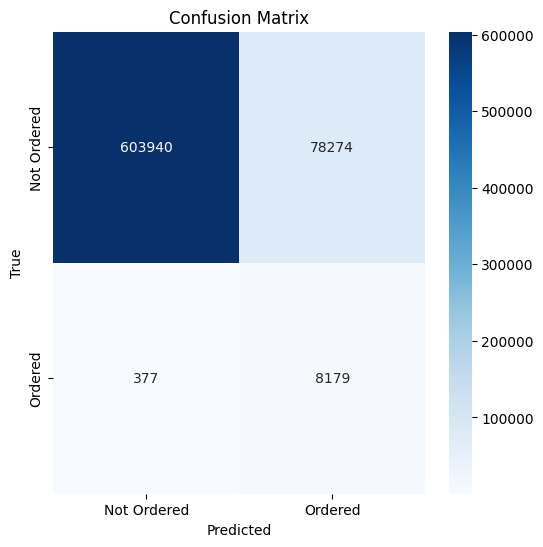

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    682214
           1       0.09      0.96      0.17      8556

    accuracy                           0.89    690770
   macro avg       0.55      0.92      0.56    690770
weighted avg       0.99      0.89      0.93    690770

ROC AUC: 0.975


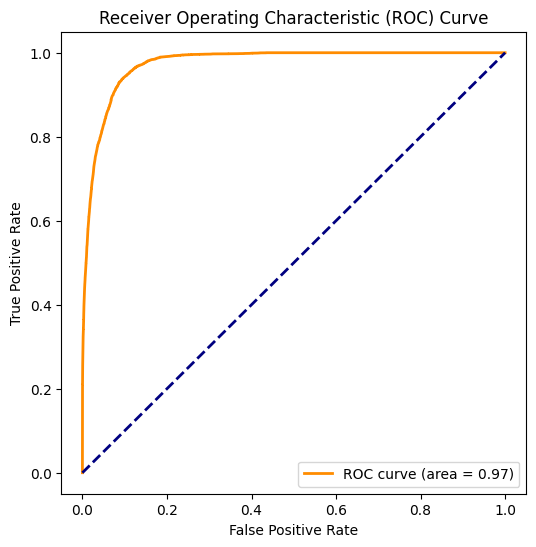

In [5]:
hgb_pred = hgb_model.predict(X_test_hgb)
cm = confusion_matrix(y_test_hgb, hgb_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Ordered', 'Ordered'], yticklabels=['Not Ordered', 'Ordered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_hgb, hgb_pred))

fpr, tpr, _ = roc_curve(y_test_hgb, hgb_model.predict_proba(X_test_hgb)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.3f}')

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Evaluating HGB over balanced batches

In [22]:
from sklearn.utils import shuffle
import numpy as np

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

# Shuffle the majority class
majority_class_shuffled = shuffle(majority_class, random_state=42)

# Calculate number of splits needed to cover the majority class
minority_class_size = len(minority_class)
num_splits = len(majority_class) // minority_class_size

# Initialize lists to store evaluation results
precision_list = []
recall_list = []
f1_list = []

# Initilize the counters for confusion matrix
TP = 0
FP = 0
TN = 0
FN = 0

# Initialize the model
model = HistGradientBoostingClassifier(
    max_bins=25, 
    max_depth=5,
    max_iter=100,
    early_stopping=True,
    n_iter_no_change=5)

# Loop to perform different splits of the majority class
for i in range(num_splits):
    # Select the subset of the majority class for this split
    start_idx = i * minority_class_size
    end_idx = (i + 1) * minority_class_size
    majority_split = majority_class_shuffled.iloc[start_idx:end_idx]
    
    # Combine the majority split with the full minority class
    balanced_data = pd.concat([majority_split, minority_class], axis=0)
    
    # Split into features (X) and target (y)
    X = balanced_data.drop(columns=['target'])
    y = balanced_data['target']
    
    # Split the dataset into train and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store the classification report for evaluation
    eval_report = classification_report(y_test, y_pred, output_dict=True)
    precision_list.append(eval_report['1']['precision'])
    recall_list.append(eval_report['1']['recall'])
    f1_list.append(eval_report['1']['f1-score'])
    
    # Update confusion matrix counters
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    TP += tp
    FP += fp
    TN += tn
    FN += fn

# Calculate the average for each metric
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print the averages
print(f"Average Precision for Class 1: {avg_precision:.3f}")
print(f"Average Recall for Class 1: {avg_recall:.3f}")
print(f"Average F1-Score for Class 1: {avg_f1:.3f}")

# Create the confusion matrix from accumulated values
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Average Precision for Class 1: 0.892
Average Recall for Class 1: 0.964
Average F1-Score for Class 1: 0.927
Confusion Matrix:
[[597443  78481]
 [ 24520 651404]]


Evaluation for KNeighborsClassifier

_WARNING: KNeighborsClassifier takes a long time to process, uncomment the cell below to use a 10:1 ratio instead of the 80:1 ratio_

In [ ]:
# # Reuse scaled training data
# data = training_data 

# majority_class = data[data['target'] == 0]
# minority_class = data[data['target'] == 1]

# # Randomly shuffle the data and redistribute with a ratio of 4:1
# majority_shuffled = shuffle(majority_class, random_state=42)
# train_data = majority_shuffled.iloc[:int(len(majority_shuffled)*0.12)]

# # Concatenate back together
# train_data = pd.concat([train_data, minority_class], axis=0)

# # Define X and y
# X = train_data.drop(columns=['target'])
# y = train_data['target']

# # Split the dataset into train and test sets (80% training, 20% testing)
# X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

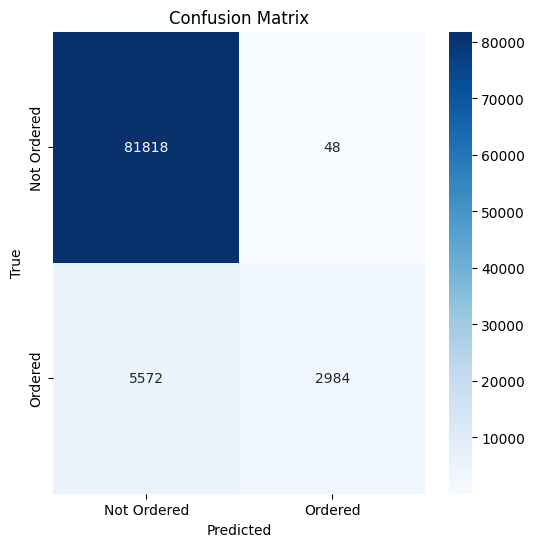

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     81866
           1       0.98      0.35      0.52      8556

    accuracy                           0.94     90422
   macro avg       0.96      0.67      0.74     90422
weighted avg       0.94      0.94      0.92     90422

ROC AUC: 0.973


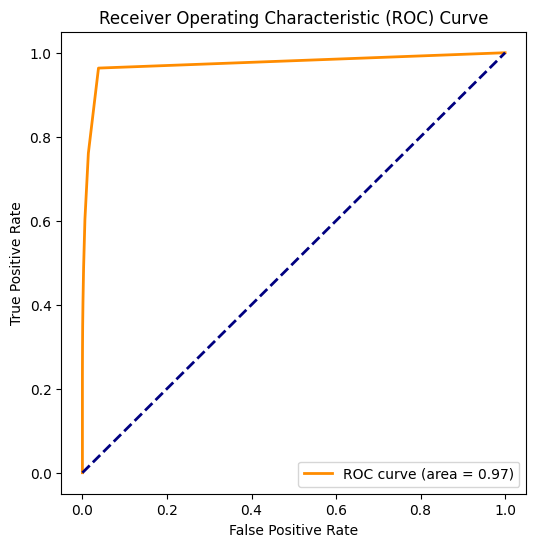

In [6]:
kn_pred = kn_model.predict(X_test_kn)
cm = confusion_matrix(y_test_kn, kn_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Ordered', 'Ordered'], yticklabels=['Not Ordered', 'Ordered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_kn, kn_pred))

fpr, tpr, _ = roc_curve(y_test_kn, kn_model.predict_proba(X_test_kn)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.3f}')

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Evaluating KNeighborsClassifier over balanced batches of data

In [20]:
from sklearn.utils import shuffle
import numpy as np

data = training_data 

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

# Shuffle the majority class
majority_class_shuffled = shuffle(majority_class, random_state=42)

# Calculate number of splits needed to cover the majority class
minority_class_size = len(minority_class)
num_splits = len(majority_class) // minority_class_size

# Initialize lists to store evaluation results
precision_list = []
recall_list = []
f1_list = []

# Initilize the counters for confusion matrix
TP = 0
FP = 0
TN = 0
FN = 0

# Initialize the model
model = KNeighborsClassifier(n_neighbors=5, n_jobs=16)

# Loop to perform different splits of the majority class
for i in range(num_splits):
    # Select the subset of the majority class for this split
    start_idx = i * minority_class_size
    end_idx = (i + 1) * minority_class_size
    majority_split = majority_class_shuffled.iloc[start_idx:end_idx]
    
    # Combine the majority split with the full minority class
    balanced_data = pd.concat([majority_split, minority_class], axis=0)
    
    # Split into features (X) and target (y)
    X = balanced_data.drop(columns=['target'])
    y = balanced_data['target']
    
    # Split the dataset into train and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store the classification report for evaluation
    eval_report = classification_report(y_test, y_pred, output_dict=True)
    precision_list.append(eval_report['1']['precision'])
    recall_list.append(eval_report['1']['recall'])
    f1_list.append(eval_report['1']['f1-score'])
    
    # Update confusion matrix counters
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    TP += tp
    FP += fp
    TN += tn
    FN += fn

# Calculate the average for each metric
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print the averages
print(f"Average Precision for Class 1: {avg_precision:.3f}")
print(f"Average Recall for Class 1: {avg_recall:.3f}")
print(f"Average F1-Score for Class 1: {avg_f1:.3f}")

# Create the confusion matrix from accumulated values
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Average Precision for Class 1: 0.895
Average Recall for Class 1: 0.958
Average F1-Score for Class 1: 0.925
Confusion Matrix:
[[599873  76051]
 [ 28647 647277]]
